# Notes

### Introduction

The idea is that we can use neural networks in combination with Q-Learning to create agents that are really good at Atari games. This paper shows how a CNN can learn successful control policies from raw data. Network is trained with a variant of the Q-learning algorithm and uses SGD to train network.

They also use an experience replay to stabalize the learning process.

**Aside: A quick summary first of what Q-learning is before we dive into the paper:**

<blockquote>

The goal of our agent is to maximize its reward. At each time step the agent, in a state, chooses an action, which brings it to a new state. The new state then gives the agent some reward. In this case the reward is the change in score of the game. The agent wants to learn a policy $\pi$ that lets it choose actions that maximize its reward.

Agents don't necessarily just care about immediate reward after the next action. It cares about the overall reward it gets in total. So an action that doesn't necessarily immediately lead to a reward could still be desired if it leads to a decent reward down the line.

This is how we calculate the reward it gets. We sum up all the rewards it gets across it's entire life.

$R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \gamma^3 r_{t+3} + \dots = \sum_{k=0}^{\infty} \gamma^k r_{t+k}$

Gamma is the discount factor. We want to weight it such that rewards we get far down the line in the future are worth less to us than immediate rewards now.

Quick aside thought experiment:

In what cases could you set the discount factor to be 1 (no discount) and have it be okay / not break evreything?

I think for tasks that have guaranteed terminal states if you have a perfect Q function that satisfies the bellman equation you could set the discount to be 1, maybe if you have a perfect Q function in a game of chess. But if you have a continuous task like balancing a pole or something then it won't work as you could have infinite future steps, meaning that every viable path can lead to an infinite return.

We see that the total future reward is a sum of all the rewards we get over all time steps, with future rewards being discounted more than near ones.

The main idea of Q-learning is to learn a function called the action-value function denoted Q(s,a). This represents the max possible future return an agent can get if it starts in states s, takes action a, and then plays optimally after that.

Obviously for most cases we can't get the perfect Q function.

To see how the Q function can be computed we use the bellman equation. The bellman equation is a recursive equation that expresses the value of a state in terms of the value of it's sucessor states.

Q-learning is the iterative algorithm that finds the Q-function by trying to satisfy the bellman equation. If the bellman equation is true for all states and actions then that is the optimal Q-function.

So the bellman equation tells us what the answer should look like, but it doesn't tell us how to find it.

The process of finding it is as follows:

We start with a wrong Q-function, either all the values are zero or are random, we repeatedly update it to make it more correct.

After the agent is in a state and performs an action, we know two important things. The immediate reward we just got, and the next state. Now, we have two estimates for a value in the Q function from the state we started in. We have the one from our Q-function, and we have one we can compute now using the bellman equation, the reward we just got + the best possible reward we can get from this new next state.

What we want to do with this information is to update our old estimate from our Q-function so that it's closer to the new value we just got (that is likely more accurate).You keep doing this until the Q-values are adjusted until it converges and satisfies the bellman equation (or as much as possible), then we have the optimal way to play the game by just using our Q-function to look up the best action to take that gives us the biggest reward.
</blockquote>

Okay so back to the paper.

So we know we want to get the Q-function, however it's probably impossible to get the actual Q function, but what we can try to get is a really good estimator of the Q-function. This is where we use a neural net. In Atari the pixel images are 210 x 160 with 128 colors, so 128 ^ 210 * 160 *theoretically* possible states (although probably much lower but still very high), impossible for us to create a table and learn the values.

So let's dive deep into how we do this. The optimal Q function obeys an important **identity** called the bellman equation. If we have the Q function that gives us the optimal / most reward over a sequence s then the optimal strategy is to pick the action that maximizes the expected value of r + that value. This is the bellman target. 

We want to get a set of weights $\theta$ such that we minimise the loss function L that changes at each iteration i:

$L_i(\theta_i) = \mathbb{E}_{s,a \sim \rho(\cdot)} [(y_i - Q(s, a; \theta_i))^2]$

where $y_i = \mathbb{E}_{s' \sim \mathcal{E}}[r + \gamma \max_{a'} Q(s', a'; \theta_{i-1}) | s, a]$ is the target for iteration i and $\rho(s, a)$ is a probability distribution over sequences s and actions a that we refer to as the behaviour distribution."

This is the standard mean squared error loss function where we want to minimize the squared difference between the target y_i and our networks prediction (given by the Q). The E notation is the expectation operator, it means that we take the average value of what's inside the brackets that follow it given that we are in state s and take action a. We need this operator because some of the environments are random meaning that taking the same action in the same state might lead to a different reward or different state. So it's the average over all the different possibillities weighted by their probability.

Our loss is the target (which is calculated from the frozen network + the reward from the tuple) - our current network squared. This is our standard MSE. We then get the gradient from this. We diffierenciate (or auto grad it) with respect to the weights.

<blockquote>

One note: we have the expectation operator in it, but we don't actually aclculate the transition probabilities or do anything with it. The expectation is done by sampling. If we do random draws enough times the results will converge to the true expectation.

To put it into a concrete example, say that when we're in a given state S we get S'1 90% of the time and S'2 10% of the time. If we get to state S 1000 times then we can expact that outcome S'1 will show up ~9x more in the training data and the gradient updates from that will be updated 9x more for that occurance. The q value will naturally converge to a value that implicitly accounts for the weighted average of the outcomes.
</blockquote>

This algorithm is model-free. It solves it using samples from the emulator directly. It's also off-policy. This means that behavior policy and target policy are different. The behavior is selected by an epsilon greedy strategy.


#### So to solidfy here's a concrete walk through of the process and one training iteration. 

Imagine we're playing breakout, we have three possible actions {move left, move right, stay}. We have a discount factor gamma of 0.9. Our online network is Q_theta_i which is the main network we're training and we have our target network Q_theta_i-1 which is a frozen older copy of our network.

**Step 1** is data generation / agent playing. Here the agent will generate a new experience to add to our memory.

The agent sees the screen and it uses the online network to decide what to do. It feeds in the state to the network and gets three Q values for the three actions, the Q value for move right is highest at 4.5. The agent follows an epsilon greedy policy and this time it chooses to not randomly explore so we pick the highest Q-value. The agent moves right and then the ball bounces and then the score increases by 5 and it advances to the next state.

The agent observes the outcome, the reward is +5 but we have clipping so the reward is clipped to +1, the state is not terminal. We store this example in the replay memory as a tuple:

(the game state when it made the action, move right, +1 reward, the state after it made the action, is_terminal_state = False)

**Step 2** is the network training part. We now draw a random mini batch from the replay memory, the tuple we just added could randomly be drawn into this. Let's say we draw a small batch of 8 experiences. We start with the first experience and perform our update.

We use the online network and feed the state into it. The network will then output Q-values for all of our actions. Let's say that the value for the action that was actually taken (stay) is predicted to be 8.2. NOTE: THIS IS NOT A LABEL AND NOT A REWARD, the 8.2 is the network's own current unverified prediction.

Now we calculate the target y_i. This is the better estimate. We use the target network (the frozen copy) for this. To get our target we take the next state (in the tuple) and feed it into our frozen network. That frozen network will output Q-values for it's predictions for all the actions. So it will output three Q values. Imagine that for this next state it outputs that Stay is 9.3, Left is 7.5, Right is 2.2. We take the max of these which is 8.8

We then plug it into the equation to get our y_j.

We have our current reward which is +1 for this tuple.

We have the max Q from the frozen which is 8.8. We have to first apply the discount factor to this though.

So our yj is = 1 (reward) + 0.9 (discount factor) * 9.3
So our yj is 9.37.

**Note Step 2 alternate (if the tuple is a terminal state)**
If it's a terminal state then y_j is just the reward without adding the predicted Q for the next state.


**Step 2.5**

Now we use these values to calculate our loss. We have from our network 8.2 and we have our yj we constructed of 9.37. That gives us our loss. We do a bit of gradient descent now.

#### That's one training iteration so let's go over the full training process from start to finish.

**Step 1**
We initialize our networks, online and target with identical random weights. We also initialize our replay memory with a capacity of 1M memories
We have some initial exploration, we do 50k steps frmo a purely random policy and fills the replay memory with some initial set of experiences

**Step 2**
We do the main training loop for maybe 10 million time steps.

Each step is as follows:
Actor takes one step in the game and stores the experience.
Learner performs one training iteration by selecting mini batch from replay buffer.

**Step 3**
Periodically, maybe every 10k time steps we pause and copy the weights from the online network to the target network.
We slowly decrease the epsilon (greedy factor) every million time steps or so.

Why is it important to have the frozen network?
It solves the moving target problem, imagine we don't use a frozen network, then our gradient descent function would be using values from our network in both the target and the prediction. This could lead to oscilations, policy churn, or divergence.

How does it converge?
It works through a process called bootstrapping or value propogation. It's constantly anchored to reality by the rewards. The information flows backwards from the future. 

### Deep Reinforcement Learning

Goal is to connect RL algorithm to a neural network that operates directly on RGB images. This part is extremely impressive to me, how do the CNN's / network learn to identify the lines / other things first?

One technique they use is the experience-replay where experiences are put into a replay memory. This has several advantages over online Q-learning. Each step of experience is used in many weight updates. Also this randomizes the order of the samples. There is strong correlation between consecutive samples so randomizing it breaks those correlations and reduces the variance of the updates.

Learning on-policy can also create unwanted feedback loops. By using the experience replay it smoothes out learning. The algorithm in practice only stores the last N experience tuples and samples uniformly.

**Preprocessing and model architecture**

Raw frames are first downsampled and put to grey scale and cropped to an 84 x 84 region. The input to the Q-function is the frame and the 3 frames before it. This gives it a little bit of state and history which I'm guessing is helpful to see which way the ball or whatever is moving, or what the state is if there's blinking in space invaders or whatever.

Their network is setup so that there is a seperate output unit for each possible action and state representation is an input to the network. Output corresponds to predicted Q-values.

Network architecture:
Input is (84 x 84) x 4 frames
First hidden layer is a convolutional layer with 16 8x8 filters with stride 4 and relu
Seoncd hiden layer is 32 4x4 filters with stride 2
Final hidden layer is fully connected 256 units.

### Experiments

They performed experiments on 7 games using the same network architecture and hyper params and learning algorithm. All positive rewards were set to be 1 negative rewards were -1. Clipping limits scale of error derivatives. This could negatively affect performance since it cannot differentiate between rewards of different magnitude. Seems like a big possible error / optimization point. They used RMSProp with minibatch size 32. Epsilon greedy with epsilon going from 1 to 0.1 over the first million frames and then 0.1 after. Replay memory of one million most recent frames.

Agent sees and selects actions on every kth frame instead of every frame.

In RL accurately evaluating progress during training can be challenging. Since evaluation is total reward it collects in an episode or game it's periodically computed during training. The average total reward tends to be noisy because small changes to the weights in the policy can have large changes in the distribution of states the policy visits.

Two left plots show how those plots which are quite noisy and looks like it's not making progerss. Another metric is the policy's estimated action-value function Q. This gives an estimate of how much discounted reward the agent can obtain. The average predicted Q increases much more smoothly than the average reward. 

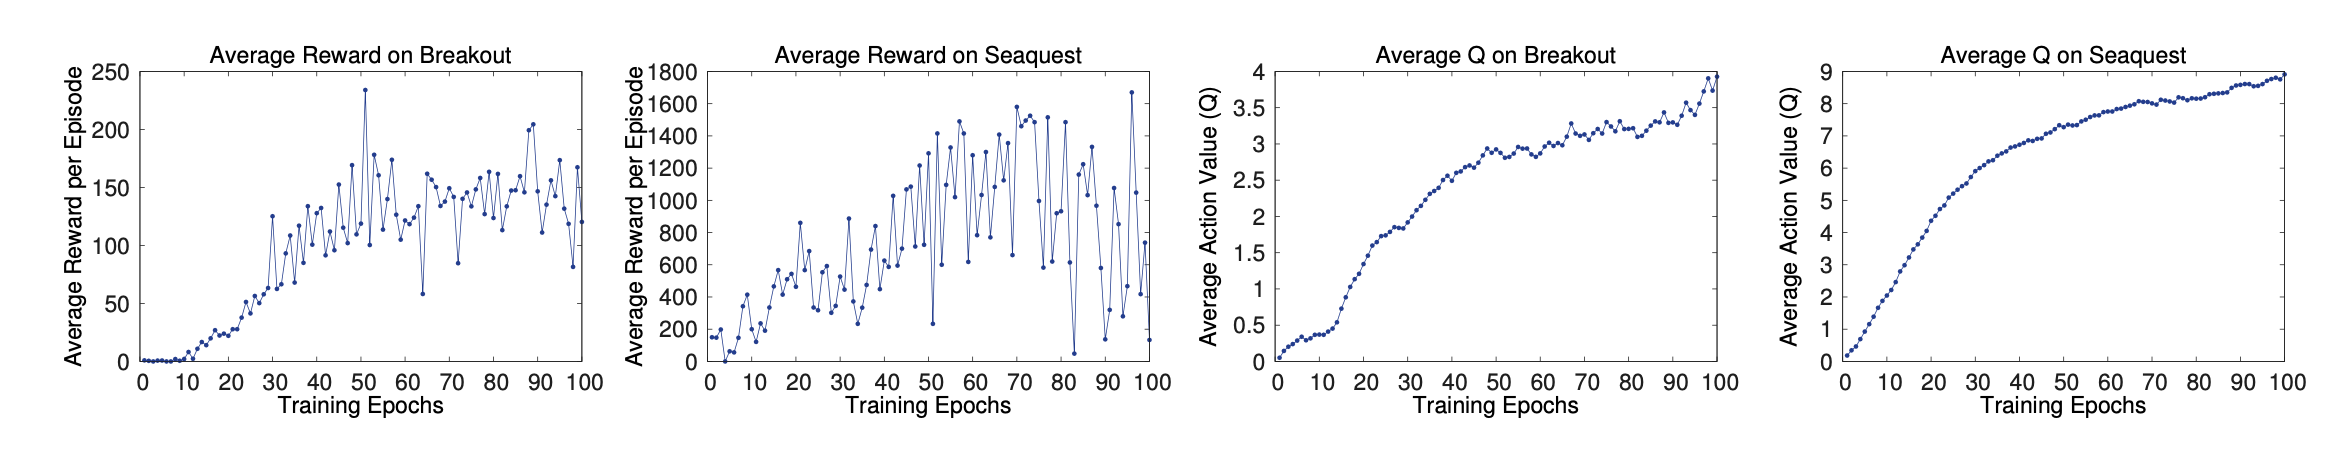

DQN performs better than other Rl algorithms and better than humans in some of them.

# Learning Implementation Assignment Plan

I should try to code one up from scratch now I'm going to run it on gynasium cart pole.

Steps

1. Understand how the environment works
2. Create a policy that just does random things and visualize it
3. Implement DQN
4. Create replay buffer class that stores the tuples
5. Create DQN Network class
6. Create the agent class that organizes everything
7. Create a visualizer class that takes in a DQN network class and just shows a visualization of playing a game with maximum greedy with it
8. Create the main training loop cell that runs everything then saves the network
9. Create ways to visualize things, render things to show, create plots that show the average q values and other charts from the paper
10. If it's easy do it on the lunar lander as well

DQN Network class should create the network, methods to run forward, methods to save the weights, method to run backward?

Agent class should have initilization that creates the two networks and replay buffer and optimizer, should take in the hyper parameters. It should have methods that play with epsilon greedy policy, it hsould have methods to learn and run backwards and step.

In [2]:
import sys
!{sys.executable} -m pip install "gymnasium[classic-control]"
import gymnasium as gym


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
# testing out environment with random
env = gym.make("CartPole-v1", render_mode="human")
observation, info = env.reset()
print(f"Starting observation: {observation}")
episode_over = False
total_reward = 0

while not episode_over:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    episode_over = terminated or truncated

print(f"Episode finished! Total reward: {total_reward}")
env.close()


Starting observation: [-3.1114818e-05  3.1605940e-02 -9.2989914e-03  4.4453889e-02]
Episode finished! Total reward: 33.0


In [4]:
from random import sample
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time

device = torch.device("mps")

class ReplayBuffer():
    def __init__(self, capacity):
        self.buffer = deque([])
        self.capacity = capacity
    
    def push(self, state, action, reward, next_state, done):
        item = [state, action, reward, next_state, done]
        if(len(self.buffer) >= self.capacity):
            self.buffer.popleft()
        self.buffer.append(item)
        
    def sample(self, batch_size):
        return sample(self.buffer, batch_size)

class DQN_Network(nn.Module):
    def __init__(self, layer_width = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, layer_width),
            nn.ReLU(),
            nn.Linear(layer_width, layer_width),
            nn.ReLU(),
            nn.Linear(layer_width,2 )
        )
        self.to(torch.device("mps"))

        
    def forward(self, x):
        return self.net(x)
        
class Agent():
    def __init__(self, buffer_size, layer_width, lr, epsilon = 0.05, discount = 0.99):
        # initialize everything
        self.replay_buffer = ReplayBuffer(buffer_size)
        self.policy_network = DQN_Network(layer_width)
        self.target_network = DQN_Network(layer_width) # the frozen one
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)
        self.epsilon = epsilon
        self.discount = discount
        self.loss = nn.MSELoss()
        self.device = torch.device("mps")

    
    def act(self, state):
        # should return which action to take
        if(random.random() <= self.epsilon):
            random_float_action = random.random()
            if random_float_action <= 0.5:
                return 1
            return 0
        # convert state to pytorch
        state_tensor = torch.tensor(state)
        state_tensor = state_tensor.to(device)
        with torch.no_grad():
            q_values = self.policy_network.forward(state_tensor)
        return q_values.argmax().item()
        
    def learn(self, batch_size = 64):
        # samples batch from buffer and then calculates everything and updates weights        
        
        # sample batch from buffer
        batch = self.replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.tensor(states, device=self.device)
        next_states = torch.tensor(next_states, device=self.device)
        rewards = torch.tensor(rewards, device=self.device)
        dones = torch.tensor(dones, device=self.device)

        
        # for each example calculate the y_i
        # to do this we first run the batch's next_states through the frozen target network to get the q values for both actions
        y_is = self.target_network.forward(next_states)

        
        # then of the q values returned for each action we just keep the larger of the two
        y_is = torch.max(y_is, dim=1)[0]

        # then we construct the y_i's by, for each, adding the reward from tuple to the max of these values multiplied by discount
        # if it is a terminal state we just return the reward, a hack is to multiply by (1 - done)
        y_is = ((self.discount * y_is) * (1 - dones) + rewards)

        # then we can use nn.MSELoss() to do the loss for each example
        # need to anki and understand this gather line
        predictions = self.policy_network.forward(states)
        predictions = predictions.gather(1, torch.tensor(actions, device=self.device).unsqueeze(1)).squeeze()


        loss = self.loss(predictions, y_is)

        self.optimizer.zero_grad()
        
        loss.backward()

        # then we run backwards and optimizer step
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())


In [6]:
# main training loop
# initialize the environment and the agent
import random


env = gym.make("CartPole-v1", render_mode="human")

# variables
buffer_size = 50000
learning_rate = 0.0005

max_steps_per_episode = 500
training_episodes = 100
reset_interval = 10

agent = Agent(buffer_size, 128, learning_rate)

# other stuff
episode_over = False
total_reward = 0


# maybe run 5 episodes first to fill the buffer?
for i in range(5):
    state = env.reset()[0]
    while not episode_over:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(action)
        episode_over = 1 if terminated or truncated else 0
        agent.replay_buffer.push(state, action, reward, next_state, episode_over)
        state = next_state

    episode_over = False


print(len(agent.replay_buffer.buffer))

# loop for a number of episodes
for episode in range(training_episodes):
    # we should fill buffer with new data from agent acting in it
    state = env.reset()[0]
    episode_over = False

    while not episode_over:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        episode_over = 1 if terminated or truncated else 0
        agent.replay_buffer.push(state, action, reward, next_state, episode_over)
        state = next_state
        agent.learn()
    
    if episode % reset_interval == 0:
        agent.update_target_network()

    



96


In [109]:
eval_env = gym.make("CartPole-v1", render_mode="human")

agent.epsilon = 0.0
agent.policy_network.eval()


num_eval_episodes = 2
for episode in range(num_eval_episodes):
    state, _ = eval_env.reset()
    
    episode_over = False
    total_reward = 0
    
    while not episode_over:
        action = agent.act(state)
        
        next_state, reward, terminated, truncated, _ = eval_env.step(action)
        
        state = next_state
        
        total_reward += reward
        
        if terminated or truncated:
            episode_over = True
            
        time.sleep(0.01)

    print(f"Evaluation Episode {episode + 1}/{num_eval_episodes}, Total Reward: {total_reward}")

eval_env.close()

Evaluation Episode 1/2, Total Reward: 500.0
Evaluation Episode 2/2, Total Reward: 500.0
